In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
import re

# Set random seed
np.random.seed(3)

# Useful shorthand
data_dir = '../data/'
out_dir = '../output/'
fig_name = 'fig_1.3_binary'
%matplotlib inline

In [2]:
style_file_name = f'{out_dir}{fig_name}.style'
s = """
    axes.linewidth:     0.5     # edge linewidth
    font.size:          7.0
    axes.labelsize:     7.0  # fontsize of the x any y labels
    xtick.labelsize:    7.0  # fontsize of the tick labels
    ytick.labelsize:    7.0  # fontsize of the tick labels
    legend.fontsize:      7.0
    legend.borderpad:     0.2  # border whitespace
    legend.labelspacing:  0.2  # the vertical space between the legend entries
    legend.borderaxespad: 0.2  # the border between the axes and legend edge
    legend.framealpha:    1.0 
    xtick.major.size:    2 
    ytick.major.size:    2
    """
with open(style_file_name, 'w') as f:
    f.write(s)
    
plt.style.use(style_file_name)

In [3]:
# Function that embeds sequence s into vector x
def s_to_x(s):
    c_to_x_dict = {
        '0':np.matrix([1, 1, 0]).T,
        '1':np.matrix([1, 0, 1]).T
    }
    x = np.matrix(1)
    for c in s:
        xl = c_to_x_dict[c]
        x = np.kron(x,xl) # Note order of multiplication
    return x

# Test
s_to_x('010')

matrix([[1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0],
        [0]])

In [4]:
# Get list of features to use throughout
def get_features(L):
    alphabet = ['*','0','1']
    features = ['']
    for l in range(L):
        features = [c+f for c in alphabet for f in features ]
    return features
features = get_features(L=3)
features

['***',
 '**0',
 '**1',
 '*0*',
 '*00',
 '*01',
 '*1*',
 '*10',
 '*11',
 '0**',
 '0*0',
 '0*1',
 '00*',
 '000',
 '001',
 '01*',
 '010',
 '011',
 '1**',
 '1*0',
 '1*1',
 '10*',
 '100',
 '101',
 '11*',
 '110',
 '111']

In [5]:
# Get list of sequences to use throughout
def get_seqs(L):
    alphabet = ['0','1']
    seqs = ['']
    for l in range(L):
        seqs = [c+s for c in alphabet for s in seqs ]
    return seqs
seqs = get_seqs(L=3)
seqs

['000', '001', '010', '011', '100', '101', '110', '111']

In [6]:
# Function to test whether features match sequences
def get_features_matched_by_s(s):
    features = get_features(L=len(s))
    features = [f.replace('*','.') for f in features]
    re_matches = np.array([int(bool(re.match(f, s))) for f in features])
    return re_matches
    
# Test whether features in fact match embedded vectors
for s in seqs:
    feature_match_vec = np.matrix(get_features_matched_by_s(s)).T
    x_vec = s_to_x(s)
    test_result = np.all(feature_match_vec == x_vec)
    print(s, ':', test_result)

000 : True
001 : True
010 : True
011 : True
100 : True
101 : True
110 : True
111 : True


In [7]:
features = get_features(L=3)
seqs = get_seqs(L=3)
alt_term=.05
theta_triv = .9*np.array([np.random.rand() + alt_term*(-1)**i if f in seqs else 0 for i,f in enumerate(features)])
theta_triv

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.45071811, 0.68233304,
       0.        , 0.30681427, 0.41474484, 0.        , 0.        ,
       0.        , 0.        , 0.84865226, 0.76166378, 0.        ,
       0.06802678, 0.23151859])

In [8]:
# Create theta_triv
# features = get_features(L=3)
# seqs = get_seqs(L=3)
# theta_triv = np.array([np.random.rand() if f in seqs else 0 for f in features])
# theta_triv

In [9]:
# Creates projection matrix given eta and L
def P_of_eta(eta, L):
    alpha=2
    Pl=np.matrix([
        [eta,        eta/alpha,     eta/alpha],
        [1-eta,    1-eta/alpha,    -eta/alpha],
        [1-eta,     -eta/alpha,   1-eta/alpha]])
    P = np.matrix([[1]])
    for l in range(L):
        P = np.kron(P,Pl) 
    return P

# Test
P_of_eta(eta=1, L=2)

matrix([[ 1.  ,  0.5 ,  0.5 ,  0.5 ,  0.25,  0.25,  0.5 ,  0.25,  0.25],
        [ 0.  ,  0.5 , -0.5 ,  0.  ,  0.25, -0.25,  0.  ,  0.25, -0.25],
        [ 0.  , -0.5 ,  0.5 ,  0.  , -0.25,  0.25,  0.  , -0.25,  0.25],
        [ 0.  ,  0.  ,  0.  ,  0.5 ,  0.25,  0.25, -0.5 , -0.25, -0.25],
        [ 0.  ,  0.  , -0.  ,  0.  ,  0.25, -0.25, -0.  , -0.25,  0.25],
        [ 0.  , -0.  ,  0.  ,  0.  , -0.25,  0.25, -0.  ,  0.25, -0.25],
        [ 0.  ,  0.  ,  0.  , -0.5 , -0.25, -0.25,  0.5 ,  0.25,  0.25],
        [ 0.  ,  0.  , -0.  , -0.  , -0.25,  0.25,  0.  ,  0.25, -0.25],
        [ 0.  , -0.  ,  0.  , -0.  ,  0.25, -0.25,  0.  , -0.25,  0.25]])

In [10]:
# Test that projection preserves sequence vector
np.all(P_of_eta(eta=.5, L=3).T * s_to_x('001') - s_to_x('001') == 0)

True

In [11]:
# Create dataframe that lists number of characters in each feature,
# the color of each feature,
# and the value of theta in the trivial gauge

# Initialize df
df = pd.DataFrame()
df['features'] = features
df['theta_triv'] = theta_triv
df['color'] = [np.zeros(4)]*len(df)

# Compute the number of characters in each feature
num_c = [3-f.count('*') for f in features]
df['num_c'] = num_c

# Make colors
white = np.array([1, 1, 1, 1])
num_c_to_base_color_dict = {
    0: np.array(to_rgba('C7')),
    1: np.array(to_rgba('C8')),
    2:np.array(to_rgba('C9')),
    3:np.array(to_rgba('C6'))}
for num_c in [0, 1, 2, 3]:
    ix = (df['num_c']==num_c)
    c = num_c_to_base_color_dict[num_c]
    sub_df = df[ix]
    n = len(sub_df)
    for m,i in enumerate(sub_df.index):
        df.at[i,'color'] = ((m+1)/n)*c + (1-((m+1)/n))*white
        
df

,features,theta_triv,color,num_c
0,***,0.000000,"[0.4980392156862745, 0.4980392156862745, 0.498...",0
1,**0,0.000000,"[0.9562091503267974, 0.9568627450980393, 0.855...",1
2,**1,0.000000,"[0.9124183006535949, 0.9137254901960785, 0.711...",1
3,*0*,0.000000,"[0.8686274509803922, 0.8705882352941177, 0.566...",1
4,*00,0.000000,"[0.9241830065359476, 0.9787581699346405, 0.984...",2
5,*01,0.000000,"[0.8483660130718954, 0.9575163398692811, 0.968...",2
6,*1*,0.000000,"[0.8248366013071896, 0.8274509803921569, 0.422...",1
7,*10,0.000000,"[0.7725490196078432, 0.9362745098039216, 0.952...",2
8,*11,0.000000,"[0.6967320261437909, 0.9150326797385622, 0.937...",2
9,0**,0.000000,"[0.7810457516339869, 0.7843137254901961, 0.277...",1


In [12]:
### Create dataframe of parameters for different values of lambda (or eta)

# Make eta grid
eta_min = -2.5
eta_max = 3.501
etas = np.arange(eta_min, eta_max, .01)
numRows=len(etas)

# Create value_df (with cols in prod_i order)
value_df = pd.DataFrame(columns=features)

# Fill in values for theta
for i in range(numRows):
    P = P_of_eta(etas[i], L=3)
    value_df.loc[i,:] = P @ theta_triv

value_df.set_index(etas, inplace=True)
value_df.index.name = 'etas'
value_df

,***,**0,**1,*0*,*00,*01,*1*,*10,*11,0**,...,011,1**,1*0,1*1,10*,100,101,11*,110,111
etas,,,,,,,,,,,,,,,,,,,,,
-2.50,-7.352484,9.968439,10.618515,11.638995,-15.879163,-16.710023,8.947959,-12.032466,-13.02182,10.250312,...,18.60769,10.336642,-14.098446,-14.844152,-16.636048,22.870718,23.710218,-12.30655,16.604932,17.853407
-2.49,-7.264606,9.859676,10.504562,11.516894,-15.72968,-16.554626,8.847344,-11.90909,-12.891897,10.139299,...,18.445538,10.224939,-13.961274,-14.701407,-16.482071,22.684774,23.517978,-12.180611,16.45165,17.693195
-2.48,-7.177432,9.7517,10.391416,11.395633,-15.58112,-16.400174,8.747482,-11.786553,-12.762833,10.029081,...,18.284337,10.114035,-13.824984,-14.559565,-16.329028,22.499849,23.326778,-12.055521,16.299301,17.533937
-2.47,-7.090958,9.644507,10.279075,11.27521,-15.433482,-16.246663,8.648372,-11.66485,-12.634625,9.919656,...,18.124084,10.003926,-13.689574,-14.418624,-16.176919,22.315941,23.136616,-11.931279,16.147882,17.37563
-2.46,-7.005181,9.538096,10.167536,11.155621,-15.286761,-16.094092,8.55001,-11.543979,-12.507269,9.811021,...,17.964777,9.89461,-13.55504,-14.278579,-16.025739,22.133047,22.947488,-11.80788,15.997391,17.218272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3.46,19.491369,-14.480622,-13.235429,-11.280745,8.517909,7.52292,-16.435305,12.073033,11.297401,-13.940706,...,-8.478235,-13.775345,10.350452,9.23761,8.350568,-6.324934,-5.549284,11.237495,-8.39305,-7.586277
3.47,19.660858,-14.621105,-13.368705,-11.402706,8.61736,7.615886,-16.587104,12.1977,11.416217,-14.078064,...,-8.574014,-13.911746,10.462431,9.342763,8.447491,-6.403932,-5.62218,11.357703,-8.49071,-7.678469
3.48,19.831327,-14.762485,-13.502855,-11.525509,8.717571,7.709591,-16.739831,12.323212,11.535858,-14.216309,...,-8.670523,-14.049031,10.57521,9.448696,8.545162,-6.483593,-5.695718,11.478744,-8.589119,-7.771389


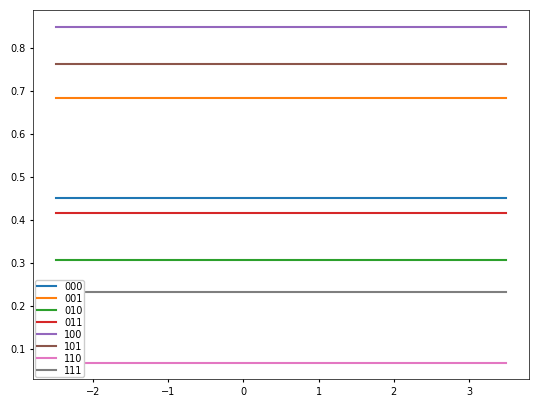

In [13]:
# Check that the gauge does not affect model preditions
def eval_model(s,theta):
    x_vec = s_to_x(s)
    theta_vec = np.matrix(theta).T
    return (x_vec.T*theta_vec).ravel()
    
# Plot values assigned to specific sequences as a function of deta
# These should all be straight lines
plt.figure()
ix = df['num_c']==3
etas = value_df.index.values
for s in seqs:
    ys = np.array([eval_model(s, theta) for eta, theta in value_df.iterrows()]).squeeze()
    plt.plot(etas, ys, label=s)
plt.legend()
plt.show()

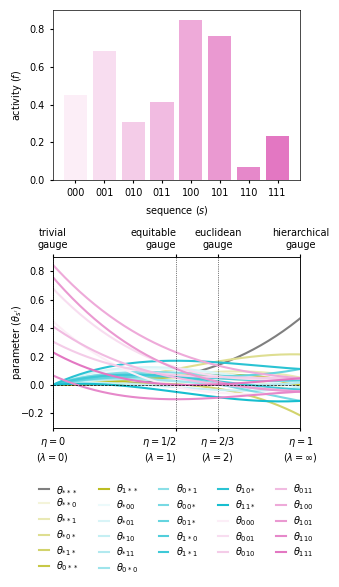

In [14]:
###
### Draw and save fig4
###
fig, axs = plt.subplots(2, 1,figsize=[3.4, 6.0])

### Panel A: sequence-function relationship
ax = axs[0]

# Get feature_sub_df, containing only bonafide sequence characters
ix = (df['num_c']==3)
sub_df = df[ix]
sub_df.reset_index(inplace=True)

# Get x values
xs = np.arange(len(sub_df))
ys = sub_df['theta_triv']
cols = sub_df['features'].values
colors = sub_df['color'].values
xticklabels = sub_df['features'].values

# Draw bar plot
for i, row in sub_df.iterrows():
    x = i
    y = row['theta_triv']
    color = row['color']
    ax.bar(x, y, width=.8, color=color)

# Style x-axis
ax.set_xticks(xs)
ax.set_xticklabels(xticklabels)
ax.set_xlabel('sequence ($s$)')

# Style y-axis
ax.set_ylim([0, .9])
ax.set_yticks([0, .2, .4, .6, .8])
ax.set_ylabel('activity ($f$)')


### Panel B: plot parameter values
ax = axs[1]

# Order features by number of *, than alphabetical
sorted_df = df.sort_values(by=['num_c', 'features'])

# Plot a curve for each parameter
for i, row in sorted_df.iterrows():
    col = row['features']
    color = row['color']
    etas = value_df.index
    thetas = value_df[col]
    ax.plot(etas, 
            thetas, 
            color=color, 
            label=r'$\theta_{\rm{' + col + r'}}$')
    
# Draw vertical lines for specific eta values
for eta in [0, 1/2, 2/3, 1]:
    ax.axvline(eta, linestyle=':', linewidth=.5, color='k')
    
# Draw horizontal aline at zero
ax.axhline(0, color='k', linewidth=.5, linestyle='--')
    
# Style y-axis (theta values)
ax.set_ylabel('parameter ($\\theta_{s\'}$)',
              labelpad=-2)
#ax.set_ylim([-1, 1])
ax.set_yticks([-1, 0, 1])
    
# Style bottom x-axis (eta values)
eta_min = 0
eta_max = 1
eta_lim = [eta_min, eta_max]
eta_ticks = np.array([0, 1/2, 2/3, 1])
eta_ticklabels = ['$\eta = 0$\n($\lambda = 0$)', 
                  '$\eta = 1/2$\n($\lambda = 1$)', 
                  '$\eta = 2/3$\n($\lambda = 2$)', 
                  '$\eta = 1$\n($\lambda = \infty$)']
gauge_labels = np.array([
    'trivial', 
    'equitable',
    'euclidean', 
    'hierarchical'
])
gauge_labels = [g+'\ngauge' for g in gauge_labels]

# Style main axes
ax.set_xlim(eta_lim)
ax.set_xticks(eta_ticks)
ax.set_xticklabels(eta_ticklabels)
#ax.set_xlabel('$\eta$', labelpad=0)
    
# Style top axes
ax2 = ax.twiny()
ax2.set_xlim(eta_lim)
ax2.set_xticks(eta_ticks)
#ax2.set_xticklabels(['0', '1', '2', '$\infty$'])
#ax2.set_xlabel('$\lambda$', labelpad=0)
ax2.set_xticklabels(gauge_labels, 
                    rotation=0,
                    ha='center',
                    va='bottom')

# Realign tick labels to avoid overlaps
ticklabels1 = ax.get_xticklabels()
#ticklabels1[0].set_ha("left")
ticklabels1[1].set_ha("right")
#ticklabels1[3].set_ha("right")

ticklabels2 = ax2.get_xticklabels()
#ticklabels2[0].set_ha("left")
ticklabels2[1].set_ha("right")
#ticklabels2[3].set_ha("right")

# Draw legend
ax.legend(bbox_to_anchor=(0.5, -.3), 
          loc='upper center', 
          handlelength=1,
          frameon=False,
            ncol=5)

ax.set_ylim([-.3, .9])
ax.set_yticks([-.2, 0, .2, .4, .6, .8])

# Tighten layout and save
fig.tight_layout()
fig.savefig(f'{out_dir}{fig_name}_ipynb.pdf', facecolor='none')